In [132]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import utils.minimization as minim

In [ ]:
# Reloading modules
importlib.reload(minim)

In [133]:
x = pd.read_csv('parkinsons_updrs.csv')
features = x.columns  # first columns will contain the names of the features
print(f'Dataset size = {x.shape}')
print(f'Dataset features count = {len(features)}')
# print(features)

Dataset size = (5875, 22)
Dataset features count = 22


Features list:
- subject#: patient number
- age: age of the patient
- sex: sex of the patient
- test_time: period from the beginning of the measurement (integer -> day, float -> hour from 0AM to 12PM)
- motor_UPDRS:
- total_UPDRS:
Jitter, in general, is the variation of the fundamental frequency in signals that should be periodic but are not
- Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5, Jitter:DDP
Shimmer, in general, is the variation of amplitude in signals that should be periodic but are not
- Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shipper:APQ11, Shimmer:DDA
- NHR: Noise to Harmonics Ratio
- HNR: Harmonic to Noise Ratio
- RPDE: Recurrence Period Density Entropy
- DFA: Detrended Fluctuation Analysis
- PPE: Perceived Vocal Effort is the measure of effort (physical and cognitive) used to produce speech

<Axes: ylabel='Frequency'>

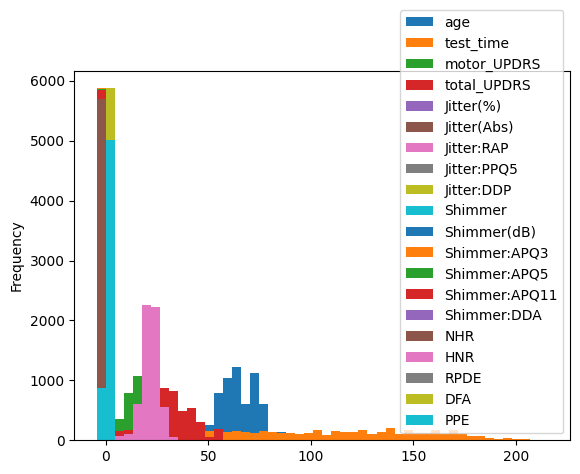

In [134]:
# print(pd.unique(x['subject#']))
# x.plot.scatter('subject#', 'age')
x.loc[:, ~x.columns.isin(['subject#', 'sex'])].plot.hist(
    bins=50)  # 'subject#' and 'sex' are removed to have a clearer histogram
# bins is the number of rectangles, so the lesser -> the more values will be represented with a single rectangle

In [135]:
X = pd.DataFrame()
subj = np.unique(x['subject#'])
for k in subj:  # for each subject#
    xk = x[x['subject#'] == k]
    xk1 = xk.copy()
    xk1.test_time = xk1.test_time.astype(int)
    xk1['g'] = xk1['test_time']  # new property called 'g' containing the 'test_time' property
    # now the dataframe collapses using 'g' as pivot, and computing the mean for each other property
    v = xk1.groupby('g').mean()
    X = pd.concat([X, v], axis=0, ignore_index=True)  # axis=0 -> concatenation along rows. (0, 1) -> (rows, columns)
features = x.columns
Np, Nc = X.shape
print(f'X shape = {X.shape}')

X shape = (990, 22)


In [136]:
Xnorm = (X - X.mean()) / X.std()
c = Xnorm.cov()

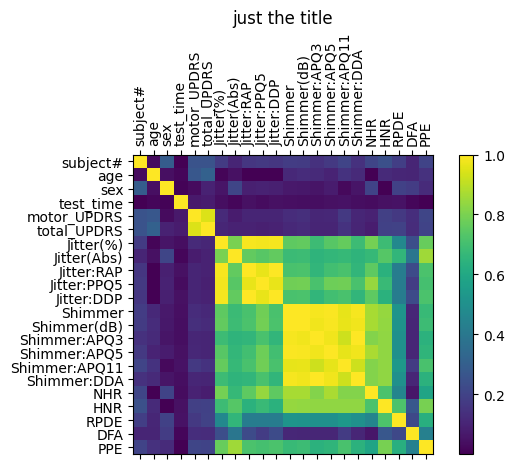

In [137]:
plt.figure()
plt.matshow(np.abs(c.values), fignum=0)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('just the title')
plt.tight_layout()
plt.savefig('./corr_coeff.png')
plt.show()

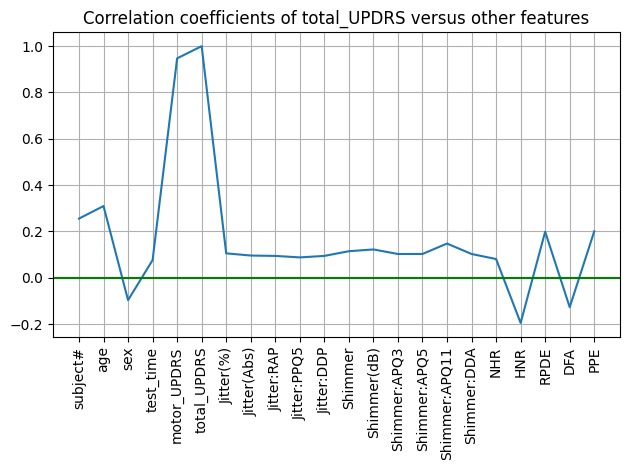

In [138]:
plt.figure()
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.axhline(y=0, color='g')
plt.title('Correlation coefficients of total_UPDRS versus other features')
plt.tight_layout()
plt.show()

In [139]:
seed = 319244
Xsh = X.sample(frac=1, replace=False, random_state=seed, axis=0, ignore_index=True)

In [140]:
# Percentages
percent_training = 0.5
percent_test = 0.25
percent_validation = 1 - percent_training - percent_test

In [141]:
Ntr = int(Np * percent_training)  # Number of training points
Nte = int(Np * percent_test)  # Number of test points
Nva = Np - Ntr - Nte

X_tr = Xsh[:Ntr]

mm = X_tr.mean()
ss = X_tr.std()
my = mm['total_UPDRS']
sy = ss['total_UPDRS']
mm_vals = mm.values
ss_vals = ss.values

In [142]:
Xsh_norm = (Xsh - mm_vals) / ss_vals  # normalization of all parameters
ysh_norm = Xsh_norm['total_UPDRS']  # total_UPDRS will be the regressand
Xsh_norm = Xsh_norm[['motor_UPDRS', 'age', 'PPE']]  # keeping only these three regressors
# Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#', 'test_time'], axis=1)  # removing the regressand and other useless
# or known correlated features

X_tr_norm = Xsh_norm[:Ntr].values
X_va_norm = Xsh_norm[Ntr:Ntr + Nva].values
X_te_norm = Xsh_norm[-Nte:].values
y_tr_norm = ysh_norm[:Ntr].values
y_va_norm = ysh_norm[Ntr:Ntr + Nva].values
y_te_norm = ysh_norm[-Nte:].values

In [143]:
# Useful functions
def eucl_distance(v1, v2):
    assert len(v1) == len(v2)
    v_diff = v1 - v2
    return pow(v_diff.T @ v_diff, 0.5)

def e_MSE(y, y_hat):
    assert len(y) == len(y_hat)
    return sum((y[i] - y_hat[i]) ** 2 for i in range(len(y)))

In [144]:
# Solver control plane
r2 = 100
t = 1
s2 = 0.001
N = 10

In [145]:
y_hat_norm = np.empty(Nva)
for row in range(Nva):
    # row = 0
    x = X_va_norm[row]
    distances = [eucl_distance(x, X_tr_norm[i]) for i in range(Ntr)]
    i_order = np.argsort(distances)
    closer_X = np.array([X_tr_norm[i] for i in i_order[:N - 1]])
    closer_y = np.array([y_tr_norm[i] for i in i_order[:N - 1]])
    Xr = np.concatenate((closer_X, [x]), axis=0)
    Rn = np.empty(shape=(N, N))
    for n in range(N):
        for k in range(N):
            Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2))
            if n == k:
                Rn[n, k] = Rn[n, k] + s2 ** 2
    k = Rn[-1, :N - 1]
    d = Rn[-1, -1]
    Rn_sub_inv = np.linalg.inv(Rn[:N - 1, :N - 1])
    y_hat_norm[row] = k.T @ Rn_sub_inv @ closer_y
    variance = d - k.T @ Rn_sub_inv @ k

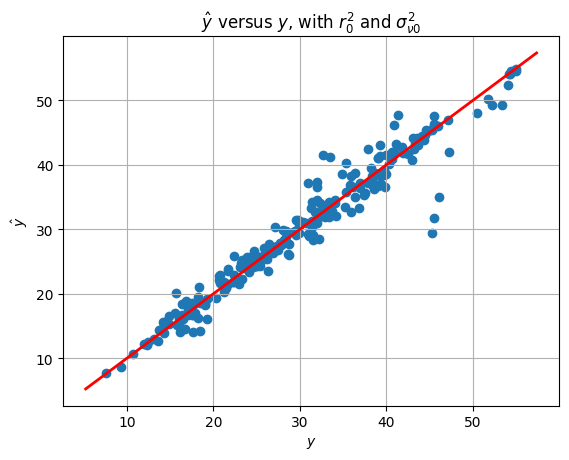

In [146]:
y_hat = y_hat_norm * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.scatter(y_va, y_hat)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_0^2$ and $\\sigma_{\\nu 0}^2$')
plt.grid()
plt.show()

In [147]:
# Grid search for r2
Nr2 = 100
r2_range = np.linspace(N, N ** 3, Nr2)
errors_r2 = np.empty(Nr2)
y_hat_norm_r2 = np.empty(Nva)
for i in range(Nr2):
    r2 = r2_range[i]
    for row in range(Nva):
        # row = 0
        x = X_va_norm[row]
        distances = [eucl_distance(x, X_tr_norm[i]) for i in range(Ntr)]
        i_order = np.argsort(distances)
        closer_X = np.array([X_tr_norm[i] for i in i_order[:N - 1]])
        closer_y = np.array([y_tr_norm[i] for i in i_order[:N - 1]])
        Xr = np.concatenate((closer_X, [x]), axis=0)
        Rn = np.empty(shape=(N, N))
        for n in range(N):
            for k in range(N):
                Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2))
                if n == k:
                    Rn[n, k] = Rn[n, k] + s2 ** 2
        k = Rn[-1, :N - 1]
        d = Rn[-1, -1]
        Rn_sub_inv = np.linalg.inv(Rn[:N - 1, :N - 1])
        y_hat_norm_r2[row] = k.T @ Rn_sub_inv @ closer_y
        variance = d - k.T @ Rn_sub_inv @ k
    errors_r2[i] = e_MSE(y_va_norm, y_hat_norm_r2)
r2_best = r2_range[np.argmin(errors_r2)]

In [148]:
# Grid search for s2
Ns2 = 100
s2_range = np.linspace(1 / N ** 4, 1 / N ** 2, Ns2)
errors_s2 = np.empty(Ns2)
y_hat_norm_s2 = np.empty(Nva)
for i in range(Ns2):
    s2 = s2_range[i]
    for row in range(Nva):
        # row = 0
        x = X_va_norm[row]
        distances = [eucl_distance(x, X_tr_norm[i]) for i in range(Ntr)]
        i_order = np.argsort(distances)
        closer_X = np.array([X_tr_norm[i] for i in i_order[:N - 1]])
        closer_y = np.array([y_tr_norm[i] for i in i_order[:N - 1]])
        Xr = np.concatenate((closer_X, [x]), axis=0)
        Rn = np.empty(shape=(N, N))
        for n in range(N):
            for k in range(N):
                Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2_best))
                if n == k:
                    Rn[n, k] = Rn[n, k] + s2 ** 2
        k = Rn[-1, :N - 1]
        d = Rn[-1, -1]
        Rn_sub_inv = np.linalg.inv(Rn[:N - 1, :N - 1])
        y_hat_norm_s2[row] = k.T @ Rn_sub_inv @ closer_y
        variance = d - k.T @ Rn_sub_inv @ k
    errors_s2[i] = e_MSE(y_va_norm, y_hat_norm_s2)
s2_best = s2_range[np.argmin(errors_s2)]

In [149]:
# Result with best r2 and s2
y_hat_norm_r2s2 = np.empty(Nva)
for row in range(Nva):
    x = X_va_norm[row]
    distances = [eucl_distance(x, X_tr_norm[i]) for i in range(Ntr)]
    i_order = np.argsort(distances)
    closer_X = np.array([X_tr_norm[i] for i in i_order[:N - 1]])
    closer_y = np.array([y_tr_norm[i] for i in i_order[:N - 1]])
    Xr = np.concatenate((closer_X, [x]), axis=0)
    Rn = np.empty(shape=(N, N))
    for n in range(N):
        for k in range(N):
            Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2_best))
            if n == k:
                Rn[n, k] = Rn[n, k] + s2_best ** 2
    k = Rn[-1, :N - 1]
    d = Rn[-1, -1]
    Rn_sub_inv = np.linalg.inv(Rn[:N - 1, :N - 1])
    y_hat_norm_r2s2[row] = k.T @ Rn_sub_inv @ closer_y
    variance = d - k.T @ Rn_sub_inv @ k

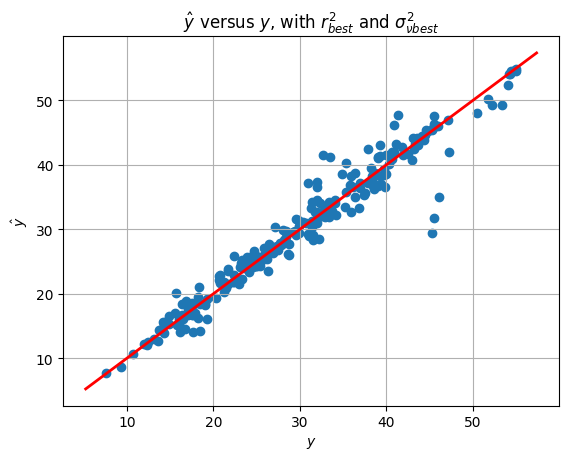

In [150]:
y_hat = y_hat_norm_r2s2 * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.scatter(y_va, y_hat)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_{best}^2$ and $\\sigma_{\\nu best}^2$')
plt.grid()
plt.show()

In [151]:
# Grid search for N
N_values = np.arange(10, 50, 1, dtype=int)
errors_N = np.empty(len(N_values))
y_hat_norm_N = np.empty(Nva)
for i in range(len(N_values)):
    N = N_values[i]
    for row in range(Nva):
        x = X_va_norm[row]
        distances = [eucl_distance(x, X_tr_norm[i]) for i in range(Ntr)]
        i_order = np.argsort(distances)
        closer_X = np.array([X_tr_norm[i] for i in i_order[:N - 1]])
        closer_y = np.array([y_tr_norm[i] for i in i_order[:N - 1]])
        Xr = np.concatenate((closer_X, [x]), axis=0)
        Rn = np.empty(shape=(N, N))
        for n in range(N):
            for k in range(N):
                Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2_best))
                if n == k:
                    Rn[n, k] = Rn[n, k] + s2 ** 2
        k = Rn[-1, :N - 1]
        d = Rn[-1, -1]
        Rn_sub_inv = np.linalg.inv(Rn[:N - 1, :N - 1])
        y_hat_norm_s2[row] = k.T @ Rn_sub_inv @ closer_y
        variance = d - k.T @ Rn_sub_inv @ k
    errors_N[i] = e_MSE(y_va_norm, y_hat_norm_s2)
N_best = N_values[np.argmin(errors_N)]

In [152]:
# Result with best r2, s2 and N
y_hat_norm_best = np.empty(Nva)
for row in range(Nva):
    x = X_va_norm[row]
    distances = [eucl_distance(x, X_tr_norm[i]) for i in range(Ntr)]
    i_order = np.argsort(distances)
    closer_X = np.array([X_tr_norm[i] for i in i_order[:N_best - 1]])
    closer_y = np.array([y_tr_norm[i] for i in i_order[:N_best - 1]])
    Xr = np.concatenate((closer_X, [x]), axis=0)
    Rn = np.empty(shape=(N_best, N_best))
    for n in range(N_best):
        for k in range(N_best):
            Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2_best))
            if n == k:
                Rn[n, k] = Rn[n, k] + s2_best ** 2
    k = Rn[-1, :N_best - 1]
    d = Rn[-1, -1]
    Rn_sub_inv = np.linalg.inv(Rn[:N_best - 1, :N_best - 1])
    y_hat_norm_best[row] = k.T @ Rn_sub_inv @ closer_y
    variance = d - k.T @ Rn_sub_inv @ k

10 90.0 0.0011


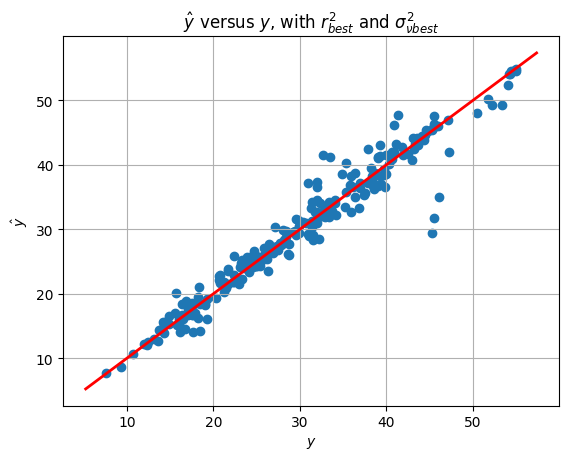

In [156]:
print(N_best, r2_best, s2_best)
y_hat = y_hat_norm_best * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.scatter(y_va, y_hat)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'r', linewidth=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_{best}^2$ and $\\sigma_{\\nu best}^2$')
plt.grid()
plt.show()